# FCN


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
import json
import h5py
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2
import torch
from torchvision import models
from functools import partial


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """
    Make a 2D bilinear kernel suitable for unsampling
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    bilinear_filter = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float32)
    weight[range(in_channels), range(out_channels), :, :] = bilinear_filter
    return torch.from_numpy(weight).float()


def bilinear_upsampling(in_channels, out_channels, kernel_size, stride, bias=False):
    initial_weight = get_upsampling_weight(in_channels, out_channels, kernel_size)
    layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, bias=bias)
    layer.weight.data.copy_(initial_weight)
    # weight is frozen because it's just a bilinear upsampling
    layer.weight.requires_grad = False
    return layer


def conv_layer(in_channels, out_channles, kernel_size, stride=1, padding=0, bias=True):
    layer = nn.Conv2d(in_channels, out_channles, kernel_size, stride, padding, bias=bias)
    layer.weight.data.zero_()
    if bias:
        layer.bias.data.zero_()
    return layer


def fully_connected(in_channels, out_channles, bias=True):
    layer = nn.Linear(in_channels, out_channles, bias=True)
    if bias:
        layer.bias.data.zero_()
    return layer


In [5]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(4, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

    def forward(self, x):
        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)

        x = self.relu3_1(self.conv3_1(x))
        x = self.relu3_2(self.conv3_2(x))
        x = self.relu3_3(self.conv3_3(x))
        x = self.pool3(x)

        x = self.relu4_1(self.conv4_1(x))
        x = self.relu4_2(self.conv4_2(x))
        x = self.relu4_3(self.conv4_3(x))
        x = self.pool4(x)

        x = self.relu5_1(self.conv5_1(x))
        x = self.relu5_2(self.conv5_2(x))
        x = self.relu5_3(self.conv5_3(x))
        x = self.pool5(x)
        return x


Define the FCN model (using VGG model):

In [6]:
class FCN16s(nn.Module):
    def __init__(self):
        super(FCN16s, self).__init__()
        self.backbone = VGG16()
        num_classes = 5

        # fc1
        self.fc1 = conv_layer(512, 4096, 7)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout2d()

        # fc2
        self.fc2 = conv_layer(4096, 4096, 1)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout2d()

        self.score_fr = conv_layer(4096, num_classes, 1)
        self.score_pool4 = conv_layer(512, num_classes, 1)

        self.upscore2 = bilinear_upsampling(num_classes, num_classes, 4, stride=2, bias=False)
        self.upscore16 = bilinear_upsampling(num_classes, num_classes, 32, stride=16, bias=False)

    def forward(self, x):
        _, _, h, w = x.size()
        x = self.backbone.conv1_1(x)
        x = self.backbone.relu1_1(x)
        x = self.backbone.conv1_2(x)
        x = self.backbone.relu1_2(x)
        x = self.backbone.pool1(x)

        x = self.backbone.conv2_1(x)
        x = self.backbone.relu2_1(x)
        x = self.backbone.conv2_2(x)
        x = self.backbone.relu2_2(x)
        x = self.backbone.pool2(x)

        x = self.backbone.conv3_1(x)
        x = self.backbone.relu3_1(x)
        x = self.backbone.conv3_2(x)
        x = self.backbone.relu3_2(x)
        x = self.backbone.conv3_3(x)
        x = self.backbone.relu3_3(x)
        x = self.backbone.pool3(x)

        x = self.backbone.conv4_1(x)
        x = self.backbone.relu4_1(x)
        x = self.backbone.conv4_2(x)
        x = self.backbone.relu4_2(x)
        x = self.backbone.conv4_3(x)
        x = self.backbone.relu4_3(x)
        x = self.backbone.pool4(x)
        pool4 = x  # 1/16

        x = self.backbone.conv5_1(x)
        x = self.backbone.relu5_1(x)
        x = self.backbone.conv5_2(x)
        x = self.backbone.relu5_2(x)
        x = self.backbone.conv5_3(x)
        x = self.backbone.relu5_3(x)
        x = self.backbone.pool5(x)
        
        x = self.relu1(self.fc1(x))
        x = self.drop1(x)

        x = self.relu2(self.fc2(x))
        x = self.drop2(x)

        x = self.score_fr(x)
        x = self.upscore2(x)
        upscore2 = x

        x = self.score_pool4(pool4)
        x = x[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = x  # 1/16

        x = upscore2 + score_pool4c

        x = self.upscore16(x)
        x = x[:, :, 27:27 + h, 27:27 + w].contiguous()
        return x

In [7]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [8]:

train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))


In [10]:
net = FCN16s().to(device,dtype=torch.float32)
net.to(device) 
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

FCN16s(
  (backbone): VGG16(
    (conv1_1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (relu1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_3):

In [13]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_3'):
    os.mkdir('Model_3')
model_save_path = 'Model_3/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

[                                                                        ]N/A% 

Starting epoch 1/100.
0.0000 --- loss: 1.609319


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 6.00 GiB total capacity; 4.57 GiB already allocated; 22.82 MiB free; 13.39 MiB cached)

In [12]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [13]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

In [14]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

In [15]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


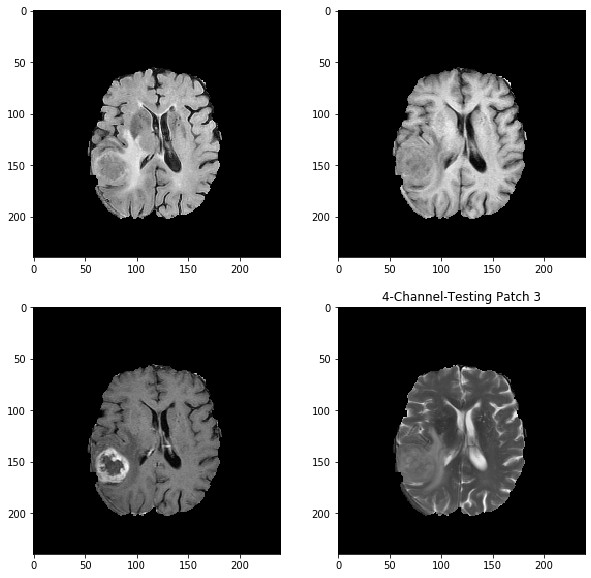

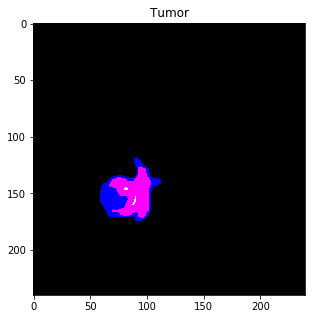

In [16]:
test_segmentation(3)    

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)
(240, 240, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


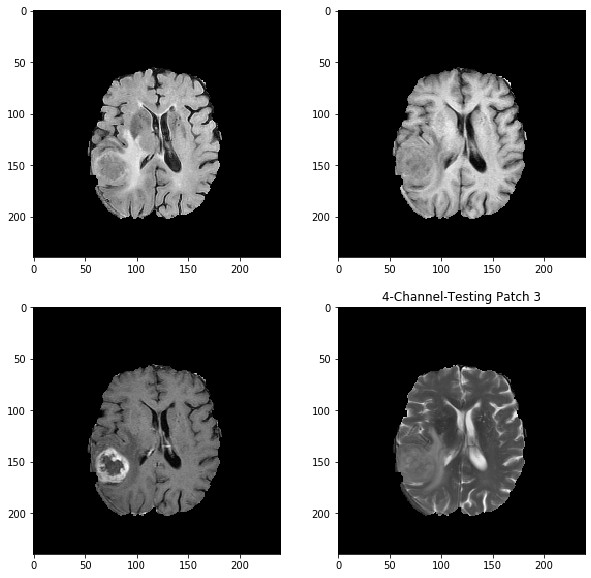

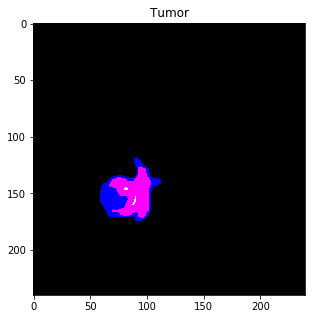

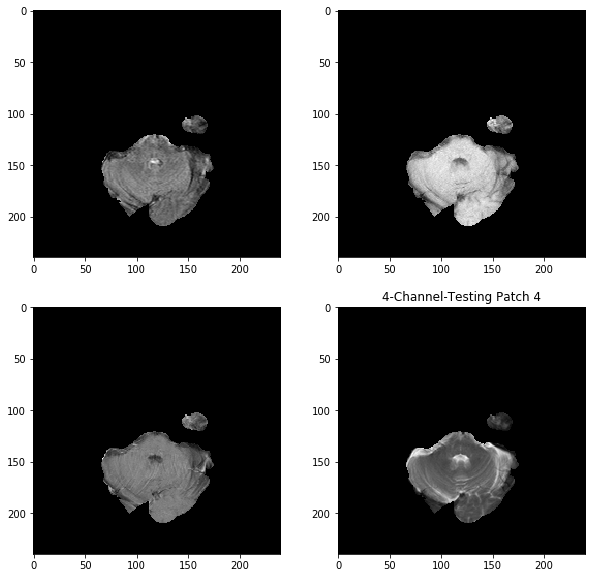

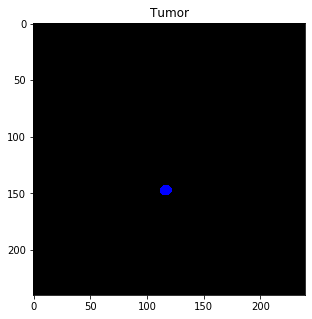

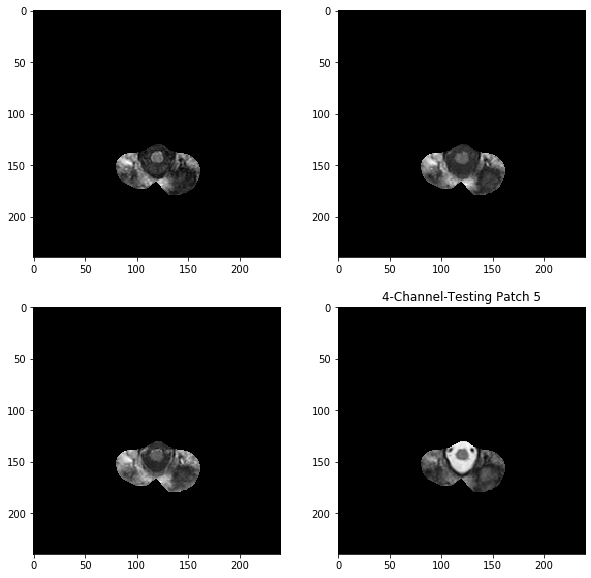

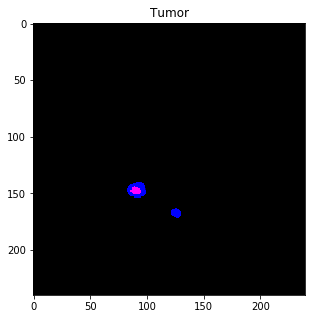

In [17]:
for i in range(3):
    test_segmentation(i+3)